# CDFS SWIRE master catalogue
## Preparation of Fireworks data

FIREWORKS photometry of GOODS CDF-S catalogue: the catalogue comes from `dmu0_Fireworks`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The total magnitude.


In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
a03d5b3 (Wed Jul 5 12:19:29 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "fireworks_ra"
DEC_COL = "fireworks_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
    'Seq':'fireworks_id', 
    'RAJ2000':'fireworks_ra', 
    'DEJ2000':'fireworks_dec',   
    'FU38':'m_fireworks_fu38', 
    'e_FU38':'merr_fireworks_fu38', 
    'FB435':'m_fireworks_fb435', 
    'e_FB435':'merr_fireworks_fb435', 
    'FB':'m_fireworks_fb', 
    'e_FB':'merr_fireworks_fb',
    'FV':'m_fireworks_fv', 
    'e_FV':'merr_fireworks_fv',
    'FV606':'m_fireworks_fv606', 
    'e_FV606':'merr_fireworks_fv606',
    'FRc':'m_fireworks_frc', 
    'e_FRc':'merr_fireworks_frc',
    'Fi775':'m_fireworks_fi775', 
    'e_Fi775':'merr_fireworks_fi775',
    'FI':'m_fireworks_fi', 
    'e_FI':'merr_fireworks_fi',
    'Fz850':'m_fireworks_fz850', 
    'e_Fz850':'merr_fireworks_fz850',
    'FJ':'m_fireworks_fj', 
    'e_FJ':'merr_fireworks_fj',
    'FH':'m_fireworks_fh', 
    'e_FH':'merr_fireworks_fh',
    'FKs':'m_fireworks_fks', 
    'e_FKs':'merr_fireworks_fks',
    #'F3.6':'m_fireworks_f3.6', 
    #'e_F3.6':'merr_fireworks_F3.6',
    #'F4.5':'m_fireworks_F4.5', 
    #'e_F4.5':'merr_fireworks_F4.5',
    #'F5.8':'m_fireworks_F5.8', 
    #'e_F5.8':'merr_fireworks_F5.8',
    #'F8.0':'m_fireworks_F8.0', 
    #'e_F8.0':'merr_fireworks_F8.0',
    'FKs.t':'m_fireworks_fkst', 
    'e_FKs.t':'merr_fireworks_fkst',
    'F24.t':'m_fireworks_f24t',
    'e_F24.t':'merr_fireworks_f24t'
    })


catalogue = Table.read("../../dmu0/dmu0_Fireworks/data/fireworks.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2008

# Clean table metadata
catalogue.meta = None

In [5]:
# Add flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        errcol = "merr{}".format(col[1:])
        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))

        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))

In [6]:
catalogue[:10].show_in_notebook()

idx,fireworks_id,fireworks_ra,fireworks_dec,m_fireworks_fu38,merr_fireworks_fu38,m_fireworks_fb435,merr_fireworks_fb435,m_fireworks_fb,merr_fireworks_fb,m_fireworks_fv,merr_fireworks_fv,m_fireworks_fv606,merr_fireworks_fv606,m_fireworks_frc,merr_fireworks_frc,m_fireworks_fi775,merr_fireworks_fi775,m_fireworks_fi,merr_fireworks_fi,m_fireworks_fz850,merr_fireworks_fz850,m_fireworks_fj,merr_fireworks_fj,m_fireworks_fh,merr_fireworks_fh,m_fireworks_fks,merr_fireworks_fks,m_fireworks_fkst,merr_fireworks_fkst,m_fireworks_f24t,merr_fireworks_f24t,f_fireworks_fu38,ferr_fireworks_fu38,flag_fireworks_fu38,f_fireworks_fb435,ferr_fireworks_fb435,flag_fireworks_fb435,f_fireworks_fb,ferr_fireworks_fb,flag_fireworks_fb,f_fireworks_fv,ferr_fireworks_fv,flag_fireworks_fv,f_fireworks_fv606,ferr_fireworks_fv606,flag_fireworks_fv606,f_fireworks_frc,ferr_fireworks_frc,flag_fireworks_frc,f_fireworks_fi775,ferr_fireworks_fi775,flag_fireworks_fi775,f_fireworks_fi,ferr_fireworks_fi,flag_fireworks_fi,f_fireworks_fz850,ferr_fireworks_fz850,flag_fireworks_fz850,f_fireworks_fj,ferr_fireworks_fj,flag_fireworks_fj,f_fireworks_fh,ferr_fireworks_fh,flag_fireworks_fh,f_fireworks_fks,ferr_fireworks_fks,flag_fireworks_fks,f_fireworks_fkst,ferr_fireworks_fkst,flag_fireworks_fkst,f_fireworks_f24t,ferr_fireworks_f24t,flag_fireworks_f24t
,,deg,deg,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,53.2033631,-27.9372714,0.379,0.03749,0.07,nan,0.536,0.01313,0.721,0.01757,1.179,0.04691,1.445,0.01582,2.636,0.06975,2.337,0.09936,3.067,0.09619,4.073,0.202,0.163,14.31,6.378,0.34084,7.421,0.3966,-20.498,7.01084,2560943517.16,88428268.3376,False,3404081897.01,nan,False,2216154325.96,26800346.3202,False,1868959971.65,30244571.8933,False,1225744632.05,52959163.043,False,959400631.516,13979194.8763,False,320331760.085,20578792.6828,False,421890746.568,38608885.2847,False,215377335.566,19081196.535,False,85270733.7344,15864524.1255,False,3124640085.81,41182747182.9,False,10204694.3194,3203511.12599,False,3904810.83749,1426357.49951,False,5.74380913496e+17,3.70890522572e+18,False
1,2,53.2103094,-27.937425,0.295,0.04015,0.148,nan,1.008,0.01386,1.655,0.01861,2.027,0.04063,2.418,0.01656,3.004,0.05869,3.398,0.10536,3.512,0.08694,3.946,0.276,-0.171,14.31,5.323,0.53908,5.976,0.60521,-0.363,0.0,2766941645.41,102320164.49,False,3168108159.33,nan,False,1434828518.23,18316349.0133,False,790678628.0,13552582.2963,False,561306407.675,21004991.1239,False,391561514.84,5972222.95556,False,228244331.217,12337858.6257,False,158781536.421,15408183.5016,False,142955214.004,11447095.7596,False,95851739.7686,24366029.299,False,4250108331.76,56016415369.6,False,26964973.6354,13388406.8006,False,14777467.0617,8237241.05471,False,5072242398.93,0.0,False
2,3,53.2042533,-27.9371053,0.239,0.04178,0.109,nan,2.189,0.01459,5.447,0.01962,8.797,0.04467,13.027,0.01763,30.494,0.06376,42.097,0.11064,47.728,0.09499,66.075,0.249,0.163,14.31,58.354,0.4049,64.601,0.44825,-11.14,6.91829,2913399222.57,112109938.847,False,3283976192.5,nan,False,483503920.592,6497270.85688,False,24054703.0499,434685.029172,False,1099512.06688,45236.7746532,False,22346.0105773,362.850722626,False,0.00230356250012,0.00013527700777,False,5.2625956208e-08,5.36275364986e-09,False,2.9430659897e-10,2.57485968632e-11,False,1.34896288259e-17,3.09367741716e-18,False,3124640085.81,41182747182.9,False,1.65348401217e-14,6.16628305839e-15,False,5.24324317246e-17,2.16469133271e-17,False,1.03752841582e+14,6.61111090559e+14,False
3,4,53.1488222,-27.9376047,0.349,0.04305,0.487,0.02308,0.46,0.01467,0.572,0.01963,0.741,0.02594,0.845,0.01759,1.515,0.03693,1.983,0.11174,2.569,0.05305,3.534,0.248,0.055,14.31,6.592,0.39171,10.279,1.5538,45.7,5.27653,2632691674.22,104387581.512,False,2318462095.41,49284628.1884,False,2376840286.62,32114842.3088,False,2143877665.97,38761089.8473,False,1834847607.76,43837487.1692,False,1667247212.55,27011053.2745,False,899497

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [8]:
SORT_COLS = ['merr_fireworks_fu38', 
     'merr_fireworks_fb435', 
     'merr_fireworks_fb',
     'merr_fireworks_fv',
     'merr_fireworks_fv606',
     'merr_fireworks_frc',
     'merr_fireworks_fi775',
     'merr_fireworks_fi',
     'merr_fireworks_fz850',
     'merr_fireworks_fj',
     'merr_fireworks_fh',
     'merr_fireworks_fks',
     #'merr_fireworks_F3.6',
     #'merr_fireworks_F4.5',
     #'merr_fireworks_F5.8',
     #'merr_fireworks_F8.0',
     'merr_fireworks_fkst',
     'merr_fireworks_f24t']
FLAG_NAME = 'fireworks_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/Users/rs548/anaconda/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 6308 sources.
The cleaned catalogue has 6308 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [9]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_CDFS-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

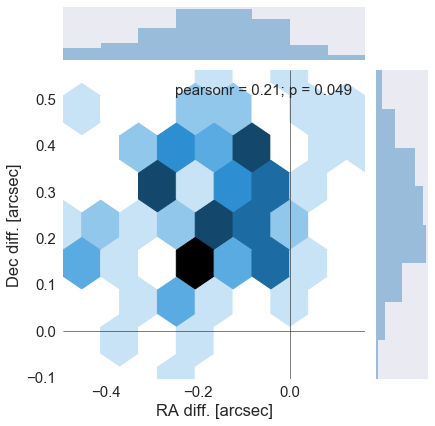

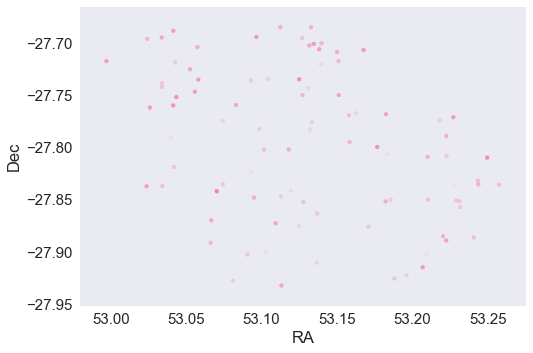

In [10]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [11]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.16079856930133474 arcsec
Dec correction: -0.2589072199192799 arcsec


In [12]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

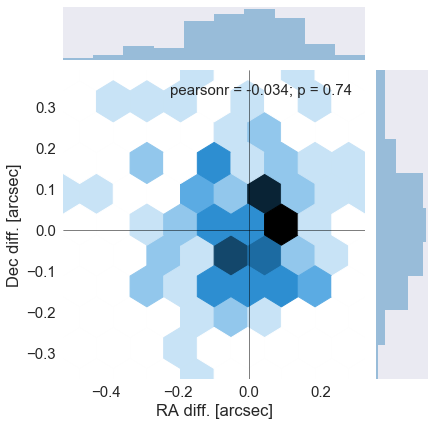

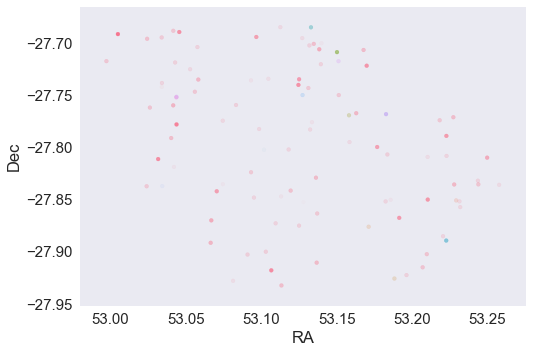

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [14]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [15]:
GAIA_FLAG_NAME = "fireworks_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

102 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [16]:
catalogue.write("{}/Fireworks.fits".format(OUT_DIR), overwrite=True)